In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [3]:
df.shape

(1235, 8)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

In [5]:
df.dtypes

Date                     object
Open                    float64
High                    float64
Low                     float64
Last                    float64
Close                   float64
Total Trade Quantity    float64
Turnover (Lacs)         float64
dtype: object

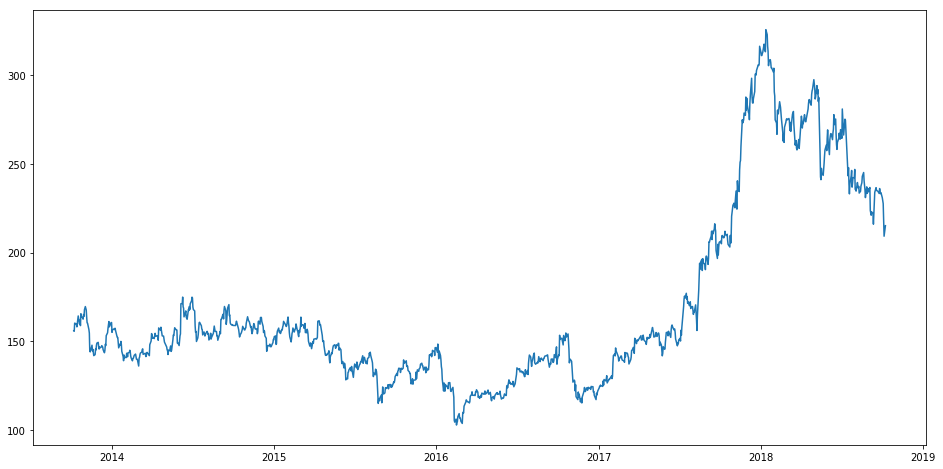

In [6]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [7]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

In [8]:
#splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

In [9]:
new_data.shape, train.shape, valid.shape

((1235, 2), (987, 2), (248, 2))

In [10]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

(Timestamp('2013-10-08 00:00:00'),
 Timestamp('2017-10-06 00:00:00'),
 Timestamp('2017-10-09 00:00:00'),
 Timestamp('2018-10-08 00:00:00'))

In [11]:
#make predictions
preds = []
for i in range(0,248):
    a = train['Close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

In [12]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
rms

104.51415465984348

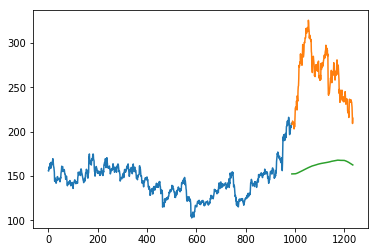

In [13]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

In [14]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [15]:
#create features
#from fastai.structured import  add_datepart
from fastai.tabular import *
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

In [16]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

In [17]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

121.16291596523415

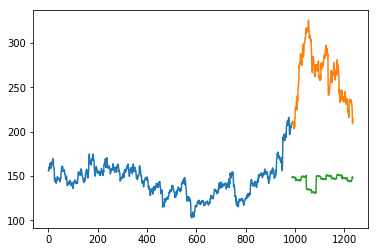

In [19]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[987:].index
train.index = new_data[:987].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

In [20]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [21]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [22]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

115.17086550026721

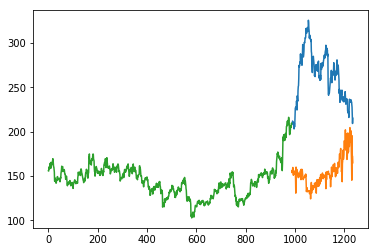

In [23]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

In [24]:
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=248)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

C:\Users\HI\Anaconda3\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4820.561, BIC=4844.968, Fit time=3.651 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5479.245, BIC=5489.008, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=1.018 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4818.530, BIC=4838.055, Fit time=3.913 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4816.433, BIC=4840.840, Fit time=2.401 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=0.889 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4818.339, BIC=4847.628, Fit time=15.548 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5481.156, BIC=5495.800, Fit time=0.230 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4818.604, BIC=4852.774, Fit time=13.238 seconds
Fit ARIMA: order=(1, 1, 1)

In [25]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

44.954451491140674

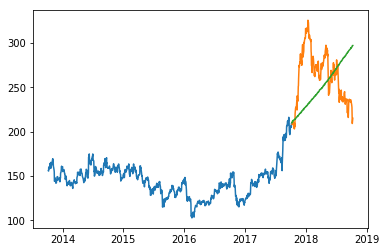

In [26]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [27]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:987]
valid = new_data[987:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
#rmse
forecast_valid = forecast['yhat'][987:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

56.93496825202469

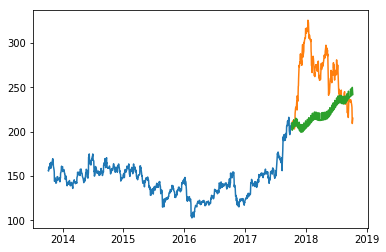

In [29]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [30]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Using TensorFlow backend.
C:\Users\HI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



Epoch 1/1
 - 48s - loss: 0.0013


In [31]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

12.37064844144649

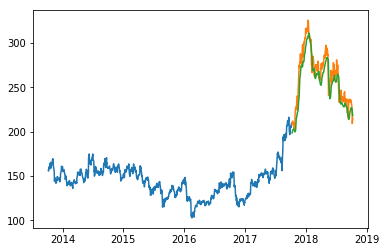

In [32]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])